Install libs

Encoder: Entrada
Hidden: Camada oculta
Decoder: Saida

An autoencoder is, by definition, a technique to encode something automatically. By using a neural network, the autoencoder is able to learn how to decompose data (in our case, images) into fairly small bits of data, and then using that representation, reconstruct the original data as closely as it can to the original.

In [0]:
!pip install -U tensorboardcolab

Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python3.6/dist-packages (0.0.22)


Imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

#from tensorboardcolab import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.inception_v3 import preprocess_input
import os
from keras.callbacks import TensorBoard

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [0]:
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=64,
                         write_images=True)


Diretórios

In [0]:
# Diretório com as imagens originais com subclasse data para gerar imagens menores para testar o código
DIR_ORIGINAL_IMAGES = './original_images'

# Diretório com as imagens originais e o subdiretório para verificar quantos imagens têm
DIR_ORIGINAL_IMAGES_DATA = './original_images/data'

# Diretório com as imagens originais sem subclasse para testar o código
DIR_OFFICIAL_IMAGES = './official_images'

# Diretório com as imagens menores para testar o código
DIR_RESIZED_IMAGES = './resized_images'

# Diretório com o resultado das imagens depois de utilizar o Autoencoder
DIR_RESULTS = './result/'

# Diretório com as imagens das métricas obtidas
DIR_METRICS = './metrics/'

TensorBoard para visualizar graficamente as métricas do modelo

In [0]:
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://d0799b12.ngrok.io


Diminiur a resolução das imagens para testar - Imagens de teste dos satélites



In [0]:
file = os.listdir(DIR_ORIGINAL_IMAGES_DATA)
size = sum(1 for img in file)

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_datagen.flow_from_directory(
    DIR_ORIGINAL_IMAGES,
    target_size=(256, 256),
    save_to_dir=DIR_RESIZED_IMAGES,
    batch_size=64,
    class_mode='input',
    color_mode='rgba')

index = 0
for batch in train_generator:
    index += 1
    if index <= size:
        break


Found 3 images belonging to 2 classes.


Classe DeepAutoencoder

In [0]:
#Salvar um modelo para cada imagem
#Recarregar esse modelo para testar com a mesma imagem
class DeepAutoencoder(object):
    
    def __init__(self, input_dim, encoded_dim):
        self.autoencoder = Sequential()

        # Encoder Layers
        self.autoencoder.add(Dense(16 * encoded_dim, input_shape=(input_dim,), activation='relu'))
        self.autoencoder.add(Dense(8 * encoded_dim, activation='relu'))
        #self.autoencoder.add(Dense(8 * encoded_dim, activation='relu'))
        #self.autoencoder.add(Dense(6 * encoded_dim, activation='relu'))
        self.autoencoder.add(Dense(4 * encoded_dim, activation='relu'))
        self.autoencoder.add(Dense(2 * encoded_dim, activation='relu'))
        self.autoencoder.add(Dense(encoded_dim, activation='relu'))
        
        self.autoencoder.add(Dropout(0.2))

        self.autoencoder.add(Dense(2 * encoded_dim, activation='relu'))
        self.autoencoder.add(Dense(4 * encoded_dim, activation='relu'))
        #self.autoencoder.add(Dense(6 * encoded_dim, activation='relu'))
        #self.autoencoder.add(Dense(8 * encoded_dim, activation='relu'))
        self.autoencoder.add(Dense(8 * encoded_dim, activation='relu'))
        self.autoencoder.add(Dense(16 * encoded_dim, activation='relu'))
        self.autoencoder.add(Dense(input_dim, activation='sigmoid'))

        self.autoencoder.summary()
        self.autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        # Decoder Layers
        self.input_img = Input(shape=(input_dim,))
        encoder_layer1 = self.autoencoder.layers[0]
        encoder_layer2 = self.autoencoder.layers[1]
        encoder_layer3 = self.autoencoder.layers[2]
        encoder_layer4 = self.autoencoder.layers[3]
        encoder_layer5 = self.autoencoder.layers[4]

        #Criação da camada oculta
        self.encoder = Model(self.input_img, 
                             encoder_layer5(encoder_layer4(encoder_layer3(encoder_layer2(encoder_layer1(self.input_img))))))
        self.encoder.summary()

    def train(self, input_train, input_test, batch_size, epochs):    
        self.autoencoder.fit(input_train, input_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=(input_test, input_test))
    
    def get_encoded_image(self, image):
        encoded_img = self.encoder.predict(image)
        return encoded_img
    
    def get_decoded_image(self, encoded_img):
        decoded_img = self.autoencoder.predict(encoded_img)
        return decoded_img

    def get_evaluate_model(self, train, test):
        score = self.autoencoder.evaluate(train, test)
        return score

    def get_history_model(self):
        return self.autoencoder.history

In [0]:
def plot_all(images):
    fig = plt.figure(figsize=(32, 32))
    number_rows = int(len(images)/3) + 1
    
    for index in range(len(images)):
        a = fig.add_subplot(number_rows, 3, index+1)
        plt.imshow(images[index])
        plt.title(f'{index}:{images[index].shape}')
        a.axis('off')
    
    fig.savefig('./metrics/compare_images.png')
    plt.show()

In [0]:
def save_image(name, image):        
    mpimg.imsave('./result/' + name, image)

In [0]:
images = []

# Normalização das imagens     
img_train = mpimg.imread('./train/_2_851641.png')
max_train_value = float(img_train.max())
train = img_train.astype('float32') / max_train_value
train = train.reshape((len(train), np.prod(train.shape[1:])))

img_test = mpimg.imread('./test/_3_7880292.png')
max_test_value = float(img_test.max())
test = img_test.astype('float32') / max_test_value
test = test.reshape((len(test), np.prod(test.shape[1:])))

# Envio da imagem para a classe DeepAutoencoder
autoencoder = DeepAutoencoder(train.shape[1], 64)
autoencoder.train(train, test, 64, 300)
            
encoded_img = autoencoder.get_encoded_image(test)
decoded_img = autoencoder.get_decoded_image(test)

history = autoencoder.get_history_model()

# Dimensões da imagem original
to_reshape = img_train.shape

# Redimensionamento das imagens obtidas
x_original_result = test.reshape(to_reshape[0], to_reshape[1], to_reshape[2])
decoded_img_result = decoded_img.reshape(to_reshape[0], to_reshape[1], to_reshape[2])      

images.append(x_original_result)
images.append(encoded_img)
images.append(decoded_img_result)

plot_all(images)

# save_image('original_' + img, x_original_result)
# save_image('encoded_img_' + img, encoded_img)
# save_image('decoded_img_' + img, decoded_img_result)

<Figure size 4032x4032 with 0 Axes>

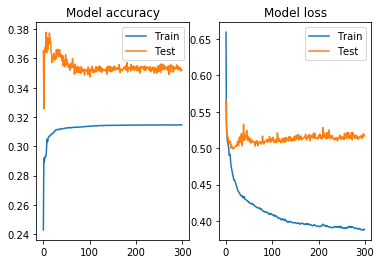

In [16]:
fig = plt.figure(figsize=(56, 56))

fig, (ax1, ax2) = plt.subplots(1, 2)



# Plot training & validation accuracy values
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('Model accuracy')
# ax1.ylabel('Accuracy')
# ax1.xlabel('Epoch')
ax1.legend(['Train', 'Test'], loc='upper right')
# ax1.show()

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
# ax2.ylabel('Loss')
# ax2.xlabel('Epoch')
ax2.legend(['Train', 'Test'], loc='upper right')
# ax2.show()



In [0]:
plot_all(images)

Outra implementação de autoencoder

In [0]:
def deep_autoencoder(input_dim, train, test, epochs, batch_size):

    input_img= Input(shape=(input_dim,))

    encoded = Dense(units=128, activation='relu')(input_dim)
    encoded = Dense(units=64, activation='relu')(encoded)

    encoded = Dense(units=32, activation='relu')(encoded)

    decoded = Dense(units=64, activation='relu')(encoded)
    decoded = Dense(units=128, activation='relu')(decoded)
    decoded = Dense(units=input_dim, activation='sigmoid')(decoded)
    
    # Building autoencoder
    autoencoder = Model(input_img, decoded)#extracting encoder
    encoder = Model(input_img, encoded)

    autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    autoencoder.summary()
    
    autoencoder.fit(train, train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(test, test))
    
    encoded_imgs = encoder.predict(image)
    decoded_imgs = autoencoder.predict(image)
    
    return (encoded_imgs, decoded_imgs)

In [0]:
plot_all(images)

Autoencoder

In [0]:
def deep_autoencoder(input_dim, encoded_dim, image, epochs, batch_size):
    autoencoder = Sequential()

    # Encoder Layers
    autoencoder.add(Dense(8 * encoded_dim, input_shape=(input_dim,), activation='relu')(input_dim))
    autoencoder.add(Dense(6 * encoded_dim, activation='relu'))
    autoencoder.add(Dense(4 * encoded_dim, activation='relu'))
    autoencoder.add(Dense(2 * encoded_dim, activation='relu'))
    autoencoder.add(Dense(encoded_dim, activation='relu'))

    autoencoder.add(Dense(2 * encoded_dim, activation='relu'))
    autoencoder.add(Dense(4 * encoded_dim, activation='relu'))
    autoencoder.add(Dense(6 * encoded_dim, activation='relu'))
    autoencoder.add(Dense(8 * encoded_dim, activation='relu'))
    autoencoder.add(Dense(input_dim, activation='sigmoid'))
    
    # Decoder Layers
    input_img = Input(shape=(input_dim,))
    encoder_layer1 = autoencoder.layers[0]
    encoder_layer2 = autoencoder.layers[1]
    encoder_layer3 = autoencoder.layers[2]
    encoder_layer4 = autoencoder.layers[3]
    encoder = Model(input_img, encoder_layer4(encoder_layer3(encoder_layer2(encoder_layer1(input_img)))))
    encoder.summary()
    
    autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    autoencoder.summary()

    autoencoder.fit(image, image,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(image, image))
    
    encoded_imgs = encoder.predict(image)
    decoded_imgs = autoencoder.predict(image)
    
    return (encoded_imgs, decoded_imgs)

Função para mostrar todas as imagens em um subplot

In [0]:
def plot_all(images):
    fig = plt.figure(figsize=(56, 56))
    number_rows = int(len(images)/3) + 1
    
    for index in range(len(images)):
        a = fig.add_subplot(number_rows, 3, index+1)
        plt.imshow(images[index])
        plt.title(f'{index}:{images[index].shape}')
        a.axis('off')
    
    # fig.savefig(DIR_METRICS + 'compare_images.png')
    plt.show()

Função para salvar as imagens

In [0]:
def save_image(name, image):        
    mpimg.imsave(DIR_RESULTS + name, image)

Função Main para codificar e decodificar as imagens de satélite (usando a função deep_autoencoder)

In [0]:
def deep_autoencoder(input_dim, train, test, epochs, batch_size):

    input_img= Input(shape=(input_dim,))

    encoded = Dense(units=128, activation='relu')(input_dim)
    encoded = Dense(units=64, activation='relu')(encoded)

    encoded = Dense(units=32, activation='relu')(encoded)

    decoded = Dense(units=64, activation='relu')(encoded)
    decoded = Dense(units=128, activation='relu')(decoded)
    decoded = Dense(units=input_dim, activation='sigmoid')(decoded)
    
    # Building autoencoder
    autoencoder = Model(input_img, decoded)#extracting encoder
    encoder = Model(input_img, encoded)
    encoder.summary()

    autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    autoencoder.summary()

    autoencoder.fit(train, train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(test, test))
    
    encoded_imgs = encoder.predict(image)
    decoded_imgs = autoencoder.predict(image)
    
    return (encoded_imgs, decoded_imgs)

def main():
    images = []
    for img in os.listdir(DIR_RESIZED_IMAGES):
        try: 
            # Normalização das imagens     
            my_image_original = mpimg.imread((os.path.join(DIR_RESIZED_IMAGES, img)))
            max_original_value = float(my_image_original.max())
            x_original = my_image_original.astype('float32') / max_original_value
            x_original = x_original.reshape((len(x_original), np.prod(x_original.shape[1:])))
            
            (encoded_img, decoded_img) = deep_autoencoder(x_original.shape[1], x_original, x_original, 20, 128)  

            # Dimensões da imagem original
            to_reshape = my_image_original.shape

            # Redimensionamento das imagens obtidas
            x_original_result = x_original.reshape(to_reshape[0], to_reshape[1], to_reshape[2])
            decoded_img_result = decoded_img.reshape(to_reshape[0], to_reshape[1], to_reshape[2])      

            images.append(x_original_result)
            images.append(encoded_img)
            images.append(decoded_img_result)

            save_image('original_' + img, x_original_result)
            save_image('encoded_img_' + img, encoded_img)
            save_image('decoded_img_' + img, decoded_img_result)

        except Exception as e:
            pass
        
    return images

Exploração das imagens

Função Main usando a classe DeepAutoencoder

In [0]:
def main_class():
    images = []
    for img in os.listdir(DIR_RESIZED_IMAGES):
        try: 
            # Normalização das imagens     
            my_image_original = mpimg.imread((os.path.join(DIR_RESIZED_IMAGES, img)))
            max_original_value = float(my_image_original.max())
            x_original = my_image_original.astype('float32') / max_original_value
            x_original = x_original.reshape((len(x_original), np.prod(x_original.shape[1:])))
            
            print(x_original.shape[1])

            # Envio da imagem para a classe DeepAutoencoder
            autoencoder = DeepAutoencoder(x_original.shape[1], 64)
            autoencoder.train(x_original, x_original, 128, 20)
                        
            encoded_img = autoencoder.getEncodedImage(x_original)
            decoded_img = autoencoder.getDecodedImage(x_original)
            
            encoded_imgs = encoder.predict(X_test)
            predicted = autoencoder.predict(X_test)

            # Dimensões da imagem original
            to_reshape = my_image_original.shape

            # Redimensionamento das imagens obtidas
            x_original_result = x_original.reshape(to_reshape[0], to_reshape[1], to_reshape[2])
            decoded_img_result = decoded_img.reshape(to_reshape[0], to_reshape[1], to_reshape[2])      

            images.append(x_original_result)
            images.append(encoded_img)
            images.append(decoded_img_result)

            # save_image('original_' + img, x_original_result)
            # save_image('encoded_img_' + img, encoded_img)
            # save_image('decoded_img_' + img, decoded_img_result)

        except Exception as e:
            print(e)
            pass
        
    return images

In [0]:
images = main_class()

Apresentação das imagens

In [0]:
plot_all(images)

----

---

----

In [0]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

#from tensorboardcolab import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.inception_v3 import preprocess_input
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# Diretório com as imagens originais com subclasse data para gerar imagens menores para testar o código
DIR_ORIGINAL_IMAGES = './original_images'

# Diretório com as imagens originais e o subdiretório para verificar quantos imagens têm
DIR_ORIGINAL_IMAGES_DATA = './original_images/data'

# Diretório com as imagens originais sem subclasse para testar o código
DIR_OFFICIAL_IMAGES = './official_images'

# Diretório com as imagens menores para testar o código
DIR_RESIZED_IMAGES = './resized_images'

# Diretório com o resultado das imagens depois de utilizar o Autoencoder
DIR_RESULTS = './result/'

# Diretório com as imagens das métricas obtidas
DIR_METRICS = './metrics/'

def plot_all(images):
    fig = plt.figure(figsize=(56, 56))
    number_rows = int(len(images)/3) + 1
    
    for index in range(len(images)):
        a = fig.add_subplot(number_rows, 3, index+1)
        plt.imshow(images[index])
        plt.title(f'{index}:{images[index].shape}')
        a.axis('off')
    
    fig.savefig(DIR_METRICS + 'compare_images.png')
    plt.show()

def deep_autoencoder(input_dim):
    print(input_dim, epochs, batch_size)
    input_img= Input(shape=(input_dim,))

    encoded = Dense(units=128, activation='relu')(input_dim)
    encoded = Dense(units=64, activation='relu')(encoded)

    encoded = Dense(units=32, activation='relu')(encoded)

    decoded = Dense(units=64, activation='relu')(encoded)
    decoded = Dense(units=128, activation='relu')(decoded)
    decoded = Dense(units=input_dim, activation='sigmoid')(decoded)
    
    # Building autoencoder
    autoencoder = Model(input_img, decoded)#extracting encoder
    encoder = Model(input_img, encoded)

    autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return autoencoder

Found 6 images belonging to 3 classes.
Found 6 images belonging to 3 classes.


TypeError: ignored

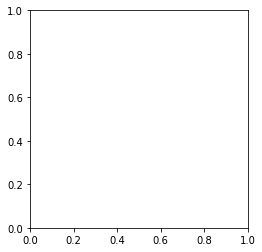

In [0]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

#from tensorboardcolab import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.inception_v3 import preprocess_input
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 



def deep_autoencoder(input_dim):
    input_img= Input(shape=(input_dim,))

    encoded = Dense(units=128, activation='relu')(input_dim)
    encoded = Dense(units=64, activation='relu')(encoded)

    encoded = Dense(units=32, activation='relu')(encoded)

    decoded = Dense(units=64, activation='relu')(encoded)
    decoded = Dense(units=128, activation='relu')(decoded)
    decoded = Dense(units=input_dim, activation='sigmoid')(decoded)
    
    # Building autoencoder
    autoencoder = Model(input_img, decoded)#extracting encoder
    encoder = Model(input_img, encoded)

    autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return autoencoder




images = []

train_data_dir = './data' #data training path
test_data_dir = './data' #data testing path

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='input',
    color_mode='rgba')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='input',
    color_mode='rgba')

for i in range(4):
	# define subplot
	# pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = train_generator.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('float32')
	# plot raw pixel data
	plt.imshow(image)

train = train_generator.next()
test = test_generator.next()

# index = 0
# for batch in test_generator:
#     plt.figure()
#     plt.imshow(batch[index][index])
#     index += 1
#     if index <= 4:
#         break

trainning = train[1][1].astype('float32') / 255
trainning = trainning.reshape((len(trainning), np.prod(trainning.shape[1:])))

testing = test[0][0].astype('float32') / 255
testing = testing.reshape((len(testing), np.prod(testing.shape[1:])))

model = deep_autoencoder(784)

history = model.fit(trainning[0][0], trainning[0][0],
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(testing[0][0], testing[0][0]))

model.save("model.h5")

score = model.evaluate_generator(test_set, 105)

print ("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))
print ("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# autoencoder = DeepAutoencoder(trainning.shape[1], 64)
# autoencoder.train(trainning, testing, 128, 20)
            
# encoded_img = autoencoder.getEncodedImage(testing)
# decoded_img = autoencoder.getDecodedImage(testing)

# to_reshape = train[1][1].shape

# Redimensionamento das imagens obtidas
# testing_result = testing.reshape(to_reshape[0], to_reshape[1], to_reshape[2])
# decoded_img_result = decoded_img.reshape(to_reshape[0], to_reshape[1], to_reshape[2])      



# plt.figure()
# plt.imshow(encoded_img)

# plt.figure()
# plt.imshow(decoded_img)

# print(to_reshape)
# print(decoded_img_result.shape)

# exit()

# images.append(testing_result)
# images.append(encoded_img)
# images.append(decoded_img)

#plot_all(images)



-----